Details of the code, how it works is available in on video - https://youtu.be/EHt_x8r1exU

In [2]:
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
openjdk version "11.0.9.1" 2020-11-04
OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [3]:
!pip install h2o

     |████████████████████████████████| 164.6MB 72kB/s 
  Created wheel for h2o: filename=h2o-3.32.0.2-py2.py3-none-any.whl size=164620456 sha256=468153db8f83394ba5846b6281ad8adf78bce71060b617389d2fc4c3b45c708d
  Stored in directory: /root/.cache/pip/wheels/42/bd/ea/218fd15724eddf6fa7fc8fab802b6fa592e623d87199679721
Successfully built h2o


In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML

In [5]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp1tcj0juc
  JVM stdout: /tmp/tmp1tcj0juc/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp1tcj0juc/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,1 month and 12 days
H2O_cluster_name:,H2O_from_python_unknownUser_lmxvnn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [6]:
nltk.download('punkt') #punkt is used for sentence tokenization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
df=pd.read_csv('https://github.com/srivatsan88/YouTubeLI/blob/master/dataset/consumer_compliants.zip?raw=true', compression='zip', sep=',', quotechar='"')

In [8]:
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,This auto loan was opened on XX/XX/2020 in XXX...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,In XXXX of 2019 I noticed a debt for {$620.00}...,None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX an...",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in...",None,CAPITAL ONE FINANCIAL CORPORATION,CA,None,None,Consent provided,Web,3/6/2020,Closed with explanation,Yes,NaN,3556237
4,2/14/2020,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,This debt was incurred due to medical malpract...,Company believes it acted appropriately as aut...,"Merchants and Professional Bureau, Inc.",OH,432XX,None,Consent provided,Web,2/14/2020,Closed with explanation,Yes,NaN,3531704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57448,2/29/2020,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,I am attempting to make a payment toward my st...,None,"Nelnet, Inc.",KS,None,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549178
57449,2/11/2020,Debt collection,Other debt,Attempts to collect debt not owed,Debt was paid,Received letter for {$480.00}. Original credit...,Company has responded to the consumer and the ...,"The Receivable Management Services LLC, New Yo...",AZ,853XX,None,Consent provided,Web,2/18/2020,Closed with explanation,Yes,NaN,3527928
57450,2/29/2020,Debt collection,Other debt,Communication tactics,"Used obscene, profane, or other abusive language",entire time 10 years until XX/XX/2020. XXXX ma...,Company has responded to the consumer and the ...,"Convergent Resources, Inc.",NJ,8101,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549238
57451,1/16/2020,Checking or savings account,Checking account,Problem with a lender or other company chargin...,Transaction was not authorized,I am a customer with Wells Fargo Bank. Recentl...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,AZ,852XX,None,Consent provided,Web,1/22/2020,Closed with explanation,Yes,NaN,3498566


In [9]:
df['Product'].value_counts()

Debt collection                21772
Credit card or prepaid card    13193
Mortgage                        9799
Checking or savings account     7003
Student loan                    2950
Vehicle loan or lease           2736
Name: Product, dtype: int64

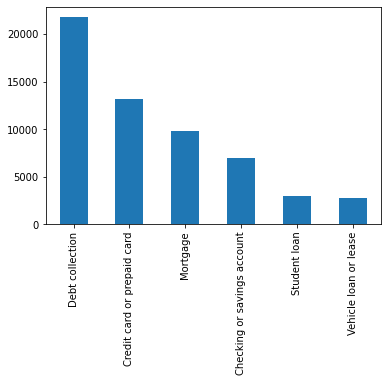

In [10]:
df['Product'].value_counts().plot(kind='bar')

In [11]:
df['Company'].value_counts()

CITIBANK, N.A.                           3226
CAPITAL ONE FINANCIAL CORPORATION        2711
BANK OF AMERICA, NATIONAL ASSOCIATION    2580
JPMORGAN CHASE & CO.                     2409
WELLS FARGO & COMPANY                    2001
                                         ... 
CrossCheck, Inc.                            1
RABOBANK, NATIONAL ASSOCIATION              1
Rocky Mountain Recovery Group               1
Premier Lending and Real Estate             1
AGN Auto Gallery Inc                        1
Name: Company, Length: 2197, dtype: int64

In [12]:
complaints_df=df[['Consumer complaint narrative','Product','Company']].rename(columns={'Consumer complaint narrative':'complaints'})

In [13]:
pd.set_option('display.max_colwidth', -1)
complaints_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,complaints,Product,Company
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked and they never

In [14]:
target={'Debt collection':0, 'Credit card or prepaid card':1, 'Mortgage':2, 'Checking or savings account':3, 'Student loan':4, 'Vehicle loan or lease':5}

In [15]:
complaints_df['target']=complaints_df['Product'].map(target)

In [16]:
complaints_df

,complaints,Product,Company,target
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION,5
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings,0
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION,5
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION,3
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked

In [17]:
X_train, X_test = train_test_split(complaints_df, test_size=0.2, random_state=111)

In [18]:
#stemmer = PorterStemmer()
stemmer = nltk.stem.SnowballStemmer('english') #it performs little better than poerterstemmer

In [19]:
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
def tokenize(text):
   tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))) > 3) ] 
   tokens = map(str.lower, tokens)
   stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
   return stems

In [21]:
#complaints_df['complaints_tok']=complaints_df['complaints'].apply(lambda x: tokenize(x))

In [22]:
vectorizer_tf = TfidfVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=1000, lowercase=False, ngram_range=(1,2))
train_vectors = vectorizer_tf.fit_transform(X_train.complaints) 

In [23]:
train_vectors.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05982223, 0.        , ..., 0.        , 0.        ,
        0.04798975],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.09582682],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [24]:
vectorizer_tf.get_feature_names()

['abil',
 'abl',
 'absolut',
 'abus',
 'accept',
 'access',
 'access account',
 'accord',
 'account',
 'account account',
 'account balanc',
 'account bank',
 'account call',
 'account close',
 'account credit',
 'account inform',
 'account number',
 'account open',
 'account report',
 'account would',
 'accru',
 'acct',
 'accur',
 'acknowledg',
 'act',
 'action',
 'activ',
 'actual',
 'ad',
 'addit',
 'address',
 'adjust',
 'admit',
 'advanc',
 'advantag',
 'advertis',
 'advis',
 'affect',
 'affidavit',
 'afford',
 'agenc',
 'agent',
 'agre',
 'agreement',
 'alert',
 'alleg',
 'alleg debt',
 'alli',
 'allow',
 'almost',
 'along',
 'alreadi',
 'also',
 'although',
 'alway',
 'america',
 'american',
 'american express',
 'amount',
 'amount owe',
 'and/or',
 'annual',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'apart',
 'appar',
 'appeal',
 'appear',
 'appli',
 'applic',
 'apprais',
 'appreci',
 'approv',
 'approxim',
 'around',
 'arrang',
 'arriv',
 'ask',
 'assess',
 'asset',
 'assign',

In [25]:
test_vectors = vectorizer_tf.transform(X_test.complaints)

In [26]:
X_train.shape

(45962, 4)

In [27]:
train_df=pd.DataFrame(train_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
train_df=pd.concat([train_df,X_train['target'].reset_index(drop=True)], axis=1)
train_df

,abil,abl,absolut,abus,accept,access,access account,accord,account,account account,account balanc,account bank,account call,account close,account credit,account inform,account number,account open,account report,account would,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,advertis,advis,affect,affidavit,afford,...,victim,victim ident,violat,visa,visit,voicemail,wage,wait,waiv,want,wasnt,websit,week,week later,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would need,would receiv,would take,write,written,wrong,wrote,year,target
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.012921,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029716,0.0,0.0,0.000000,0.026785,0.025451,0.0,0.0,0.000000,0.0,0.000000,0.029334,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.292819,0.363256,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,3
1,0.0,0.059822,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.075668,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.047990,0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.031225,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.021576,0.041002,0.0,0.0,0.032756,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.066071,0.0,0.0,0.046675,0.0,0.0,0.0,0.025086,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.021839,0.000000,0.000000,0.0,0.000000,0.026262,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.127564,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.321204,0.478162,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45957,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.056681,0.0,0.0,0.000000,0.0,0.183791,0.065329,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.060380,0.080003,0.000000,0.0,0.000000,0.108915,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1
45958,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.103402,0.0,0.166556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.

In [28]:
test_df=pd.DataFrame(test_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
test_df=pd.concat([test_df,X_test['target'].reset_index(drop=True)], axis=1)
test_df

,abil,abl,absolut,abus,accept,access,access account,accord,account,account account,account balanc,account bank,account call,account close,account credit,account inform,account number,account open,account report,account would,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,advertis,advis,affect,affidavit,afford,...,victim,victim ident,violat,visa,visit,voicemail,wage,wait,waiv,want,wasnt,websit,week,week later,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would need,would receiv,would take,write,written,wrong,wrote,year,target
0,0.0,0.086928,0.0,0.0,0.0,0.211936,0.0,0.0,0.348130,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.045103,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.043198,0.0,0.000000,0.000000,0.085755,0.000000,0.000000,0.0,0.0,0.078402,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.109801,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,3
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.124581,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,2
2,0.0,0.146798,0.0,0.0,0.0,0.000000,0.0,0.0,0.220463,0.0,0.0,0.000000,0.0,0.194989,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.239325,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,1
3,0.0,0.088469,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.033514,0.0,0.0,0.043696,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.058183,0.000000,0.044707,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.037249,0.0,0.0,0.000000,0.04532,0.0,0.0,0.0,0.0,0.0,0.070970,4
4,0.0,0.079911,0.0,0.0,0.0,0.000000,0.0,0.0,0.040004,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.118409,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.128210,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11486,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.020516,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.100242,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.064036,0.0,0.0,0.0,0.000000,0.000000,0.049446,0.040732,0.0,0.116232,0.000000,0.040429,0.000000,0.000000,0.0,0.0,0.000000,0.059952,0.000000,0.0,0.039218,0.0,0.187300,0.103532,0.0,0.0,0.129426,0.00000,0.0,0.0,0.0,0.0,0.0,0.032876,1
11487,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.183268,0.0,0.0,0.145042,0.0,0.0

**How do you know, which model works better?**

In [29]:
#Conert pd dataframe into h2o data frame
h2o_train_df = h2o.H2OFrame(train_df) 
h2o_test_df = h2o.H2OFrame(test_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [30]:
h2o_train_df.types  

{'abil': 'real',
 'abl': 'real',
 'absolut': 'real',
 'abus': 'real',
 'accept': 'real',
 'access': 'real',
 'access account': 'real',
 'accord': 'real',
 'account': 'real',
 'account account': 'real',
 'account balanc': 'real',
 'account bank': 'real',
 'account call': 'real',
 'account close': 'real',
 'account credit': 'real',
 'account inform': 'real',
 'account number': 'real',
 'account open': 'real',
 'account report': 'real',
 'account would': 'real',
 'accru': 'real',
 'acct': 'real',
 'accur': 'real',
 'acknowledg': 'real',
 'act': 'real',
 'action': 'real',
 'activ': 'real',
 'actual': 'real',
 'ad': 'real',
 'addit': 'real',
 'address': 'real',
 'adjust': 'real',
 'admit': 'real',
 'advanc': 'real',
 'advantag': 'real',
 'advertis': 'real',
 'advis': 'real',
 'affect': 'real',
 'affidavit': 'real',
 'afford': 'real',
 'agenc': 'real',
 'agent': 'real',
 'agre': 'real',
 'agreement': 'real',
 'alert': 'real',
 'alleg': 'real',
 'alleg debt': 'real',
 'alli': 'real',
 'allow'

In [31]:
h2o_train_df['target'].types #target should not be integer otherwise h2o treat it as regression problem

{'target': 'int'}

In [32]:
h2o_train_df['target'] = h2o_train_df['target'].asfactor()
h2o_test_df['target'] = h2o_test_df['target'].asfactor()

In [33]:
#target column type should be enumerous type for text classification
h2o_train_df['target'].types 

{'target': 'enum'}

#H2O pipeline

In [34]:
aml = H2OAutoML(max_models = 5, seed = 10, exclude_algos = ["StackedEnsemble"], verbosity="info", nfolds=0, balance_classes=True, max_after_balance_size=0.3)

In [35]:
x=vectorizer_tf.get_feature_names()
y='target'

In [36]:
aml.train(x = x, y = y, training_frame = h2o_train_df, validation_frame=h2o_test_df)

AutoML progress: |
15:21:01.869: Project: AutoML_20201230_152101866
15:21:01.870: Cross-validation disabled by user: no fold column nor nfolds > 1.
15:21:01.900: Setting stopping tolerance adaptively based on the training frame: 0.00466445106034528
15:21:01.900: Build control seed: 10
15:21:01.901: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
15:21:07.390: training frame: Frame key: automl_training_py_1_sid_8928    cols: 1001    rows: 41253  chunks: 53    size: 34326323  checksum: -3708572512705517030
15:21:07.395: validation frame: Frame key: py_2_sid_8928    cols: 1001    rows: 11491  chunks: 14    size: 9663839  checksum: 6186608125092982850
15:21:07.730: leaderboard frame: Frame key: automl_leaderboard_py_1_sid_8928    cols: 1001    rows: 4709  chunks: 53    size: 7556253  checksum: 384529285802033387
15:21:07.730: blending frame: NULL
15:21:07.731: response c

In [37]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_2_AutoML_20201230_152101,0.151607,0.3315,0.307789,0.0947342
XGBoost_3_AutoML_20201230_152101,0.153793,0.33175,0.313482,0.0982707
XGBoost_1_AutoML_20201230_152101,0.154777,0.335565,0.31218,0.0974565
GLM_1_AutoML_20201230_152101,0.170193,0.379036,0.335487,0.112552
DRF_1_AutoML_20201230_152101,0.277178,0.592434,0.443854,0.197007


In [38]:
pred=aml.leader.predict(h2o_test_df)

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [39]:
aml.leader.model_performance(h2o_test_df)


ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 0.09580208143934055
RMSE: 0.3095191132052115
LogLoss: 0.3330637004461808
Mean Per-Class Error: 0.15823994814305678

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,3996.0,126.0,58.0,30.0,40.0,45.0,0.069616,"299 / 4,295"
1,159.0,2275.0,24.0,106.0,2.0,17.0,0.119241,"308 / 2,583"
2,63.0,33.0,1855.0,18.0,12.0,34.0,0.079404,"160 / 2,015"
3,46.0,135.0,21.0,1252.0,1.0,6.0,0.143053,"209 / 1,461"
4,65.0,19.0,25.0,1.0,482.0,19.0,0.211129,129 / 611
5,78.0,39.0,39.0,9.0,7.0,354.0,0.326996,172 / 526
6,4407.0,2627.0,2022.0,1416.0,544.0,475.0,0.111130,"1,277 / 11,491"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.888869
1,2,0.963885
2,3,0.985554
3,4,0.993908
4,5,0.998434
5,6,1.000000


Gives the hyper parameter that H2O uses...

In [40]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])

In [61]:
model_ids

['XGBoost_2_AutoML_20201230_152101',
 'XGBoost_3_AutoML_20201230_152101',
 'XGBoost_1_AutoML_20201230_152101',
 'GLM_1_AutoML_20201230_152101',
 'DRF_1_AutoML_20201230_152101']

In [41]:
out

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20201230_152101


Model Summary: 


,,number_of_trees
0,,75.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.027045769139722887
RMSE: 0.1644559793370946
LogLoss: 0.10444530084969711
Mean Per-Class Error: 0.0336917353617761

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,15478.0,93.0,35.0,30.0,18.0,15.0,0.012190,"191 / 15,669"
1,174.0,9279.0,12.0,41.0,7.0,7.0,0.025315,"241 / 9,520"
2,61.0,43.0,6891.0,8.0,2.0,5.0,0.016976,"119 / 7,010"
3,44.0,51.0,8.0,4891.0,0.0,4.0,0.021409,"107 / 4,998"
4,52.0,36.0,6.0,1.0,1994.0,4.0,0.047301,"99 / 2,093"
5,82.0,55.0,7.0,5.0,6.0,1808.0,0.078961,"155 / 1,963"
6,15891.0,9557.0,6959.0,4976.0,2027.0,1843.0,0.022107,"912 / 41,253"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.977893
1,2,0.994449
2,3,0.998012
3,4,0.999394
4,5,0.999806
5,6,1.000000



ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.09580208143934055
RMSE: 0.3095191132052115
LogLoss: 0.3330637004461808
Mean Per-Class Error: 0.15823994814305678

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,3996.0,126.0,58.0,30.0,40.0,45.0,0.069616,"299 / 4,295"
1,159.0,2275.0,24.0,106.0,2.0,17.0,0.119241,"308 / 2,583"
2,63.0,33.0,1855.0,18.0,12.0,34.0,0.079404,"160 / 2,015"
3,46.0,135.0,21.0,1252.0,1.0,6.0,0.143053,"209 / 1,461"
4,65.0,19.0,25.0,1.0,482.0,19.0,0.211129,129 / 611
5,78.0,39.0,39.0,9.0,7.0,354.0,0.326996,172 / 526
6,4407.0,2627.0,2022.0,1416.0,544.0,475.0,0.111130,"1,277 / 11,491"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.888869
1,2,0.963885
2,3,0.985554
3,4,0.993908
4,5,0.998434
5,6,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
0,,2020-12-30 15:23:18,0.013 sec,0.0,0.833333,1.791759,0.830073,0.833333,1.791759,0.824645
1,,2020-12-30 15:23:43,25.119 sec,5.0,0.448321,0.606908,0.114949,0.468508,0.656358,0.141502
2,,2020-12-30 15:24:02,43.474 sec,10.0,0.334795,0.372666,0.093011,0.375110,0.454757,0.131407
3,,2020-12-30 15:24:18,1 min 0.347 sec,15.0,0.291100,0.285404,0.078322,0.346171,0.391433,0.124445
4,,2020-12-30 15:24:35,1 min 16.866 sec,20.0,0.265984,0.239520,0.067341,0.332545,0.363869,0.121225
5,,2020-12-30 15:24:53,1 min 35.000 sec,25.0,0.247432,0.209249,0.058808,0.324798,0.349971,0.117048
6,,2020-12-30 15:25:13,1 min 55.093 sec,30.0,0.234043,0.188900,0.052336,0.320734,0.343231,0.115482
7,,2020-12-30 15:25:32,2 min 13.828 sec,35.0,0.222221,0.172429,0.047172,0.317288,0.338037,0.113741
8,,2020-12-30 15:25:52,2 min 33.736 sec,40.0,0.212618,0.159591,0.042421,0.315460,0.335677,0.113567
9,,2020-12-30 15:26:13,2 min 54.595 sec,45.0,0.203545,0.148131,0.038252,0.313812,0.334216,0.112523



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,debt,15688.623047,1.000000,0.102429
1,card,12361.398438,0.787921,0.080706
2,mortgag,11345.549805,0.723171,0.074074
3,loan,8262.434570,0.526651,0.053944
4,bank,7164.359863,0.456660,0.046775
5,collect,4369.185059,0.278494,0.028526
6,credit card,4071.709229,0.259533,0.026584
7,payment,4004.601318,0.255255,0.026146
8,account,3416.742676,0.217785,0.022307
9,vehicl,2746.517578,0.175064,0.017932



See the whole table with table.as_data_frame()


Convert H2O parameters into XGB parameters so that we can use sklearn on that

In [42]:
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'alpha': 0.0,
  'booster': 'gbtree',
  'colsample_bylevel': 0.8,
  'colsample_bytree': 0.8,
  'eta': 0.3,
  'gamma': 0.0,
  'grow_policy': 'depthwise',
  'lambda': 1.0,
  'max_delta_step': 0.0,
  'max_depth': 20,
  'min_child_weight': 10.0,
  'nround': 10000,
  'nthread': 2,
  'num_class': 6,
  'objective': 'multi:softprob',
  'seed': 11,
  'silent': True,
  'subsample': 0.6,
  'tree_method': 'exact'},
 10000)

In [43]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

In [44]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, objective='multi:softprob', random_state=10, **{"updater": "grow_gpu"})

In [45]:
xgb_clf.fit(train_vectors, X_train['target'])

[15:42:33] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, updater='grow_gpu', verbosity=1)

In [46]:
predictions = xgb_clf.predict(test_vectors)

In [47]:
cm = confusion_matrix(X_test['target'], predictions)
print(cm)

[[3941  156   63   37   46   52]
 [ 282 2177   13   99    1   11]
 [  97   38 1822   24    8   26]
 [  89  131   21 1213    0    7]
 [  77   23   29    2  461   19]
 [ 107   53   35    9    4  318]]


In [48]:
print('classification_report :\n',classification_report(X_test['target'], predictions))

classification_report :
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      4295
           1       0.84      0.84      0.84      2583
           2       0.92      0.90      0.91      2015
           3       0.88      0.83      0.85      1461
           4       0.89      0.75      0.82       611
           5       0.73      0.60      0.66       526

    accuracy                           0.86     11491
   macro avg       0.85      0.81      0.83     11491
weighted avg       0.86      0.86      0.86     11491



In [49]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(X_train['target']),
                                             X_train['target']))

In [50]:
class_weights

[0.43830939711239536,
 0.7219918316054037,
 0.9841127098321343,
 1.382232647660291,
 3.275046316089497,
 3.466214177978884]

In [51]:
weights = np.ones(X_train.shape[0], dtype = 'float')

In [52]:
weights

array([1., 1., 1., ..., 1., 1., 1.])

In [53]:
for i, val in enumerate(X_train['target']):
    weights[i] = class_weights[val]

In [54]:
weights

array([1.38223265, 0.4383094 , 0.4383094 , ..., 0.72199183, 0.72199183,
       0.98411271])

In [55]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, objective='multi:softprob', random_state=10, **{"updater": "grow_gpu"})

In [56]:
xgb_clf.fit(train_vectors, X_train['target'], sample_weight=weights)

[15:42:52] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, updater='grow_gpu', verbosity=1)

In [57]:
#print("Accuracy score (test): {0:.3f}".format(xgb_clf.score(test_vectors, X_test['target'])))

In [58]:
predictions = xgb_clf.predict(test_vectors)

In [59]:
cm = confusion_matrix(X_test['target'], predictions)
print(cm)

[[3649  186   81  110   90  179]
 [ 167 2107   18  178    2  111]
 [  41   20 1784   30   52   88]
 [  33   94   16 1291    5   22]
 [  25    6    4    2  515   59]
 [  48   21    9   13   21  414]]


In [60]:
print('classification_report :\n',classification_report(X_test['target'], predictions))

classification_report :
               precision    recall  f1-score   support

           0       0.92      0.85      0.88      4295
           1       0.87      0.82      0.84      2583
           2       0.93      0.89      0.91      2015
           3       0.79      0.88      0.84      1461
           4       0.75      0.84      0.79       611
           5       0.47      0.79      0.59       526

    accuracy                           0.85     11491
   macro avg       0.79      0.84      0.81     11491
weighted avg       0.87      0.85      0.85     11491



-----------------